# varlib demo

## Variable definitions

variables can be defined in a yaml file:

## Variable definition parsing and dependency graph

varlib can load the variable definitions from yaml file, parse them and build a dependency graph solely from the information in the variable definitions. The dependency graph is in networkx directed acyclic graph (DAG) format.

**Visualize the depedency graph**

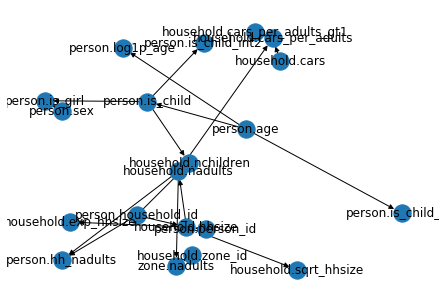

In [18]:
import networkx as nx
from varlib.parse import build_graph
import itertools

dep_graph = build_graph("variables.yml")

nx.draw(dep_graph, with_labels = True)

**Visualize the depedency graph (interactive)**

In [16]:
from pyvis.network import Network
VG = Network(notebook=True)
VG.from_nx(dep_graph)
#VG.enable_physics(True)
VG.show("dep_graph.html")

## Utilizing the dependency graph in variable computation

In [36]:
from varlib.compute import compute
import pandas as pd
import numpy as np
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG)

pp_data = {'person_id': [1, 2, 3, 4],
        'household_id': [1, 1, 2, 2],
        'age':[2,   26,  39, 10],
        'sex':['F', 'F', 'M', 'M']}
person = pd.DataFrame(pp_data).set_index("person_id")
person.name = "person"

resolvers={'person': person}

person

,household_id,age,sex
person_id,,,
1,1,2,F
2,1,26,F
3,2,39,M
4,2,10,M


In [42]:
compute(["person.is_girl", 'person.log1p_age'], dep_graph, resolvers=resolvers)

2019-11-28 21:34:21 INFO: Computing person.is_girl started ...
2019-11-28 21:34:21 INFO:     Computing is_girl skipped
2019-11-28 21:34:21 INFO: Computing person.is_girl done in 0.00s.
2019-11-28 21:34:21 INFO: Computing person.log1p_age started ...
2019-11-28 21:34:21 INFO:     Computing log1p_age skipped
2019-11-28 21:34:21 INFO: Computing person.log1p_age done in 0.00s.


In [43]:
person

,household_id,age,sex,is_child,is_girl,log1p_age
person_id,,,,,,
1,1,3,F,True,True,1.386294
2,1,27,F,False,False,3.332205
3,2,40,M,False,False,3.713572
4,2,11,M,True,False,2.484907


## Lazy recompute

In [44]:
col1 = person['log1p_age']
# since log1p_age has been computed before and its dependencies haven't changed
# nothing should happen if we call compute again
compute("person.log1p_age", dep_graph, resolvers=resolvers)
# the column should be the same as before
assert id(person['log1p_age']) == id(col1), "lazy recompute not enabled"

2019-11-28 21:34:35 INFO: Computing person.log1p_age started ...
2019-11-28 21:34:35 INFO:     Computing log1p_age skipped
2019-11-28 21:34:35 INFO: Computing person.log1p_age done in 0.00s.


In [45]:
# if we change age, then log1p_age will be recomputed if we call compute again
person['age'] += 1
compute("person.log1p_age", dep_graph, resolvers=resolvers)
assert id(person['log1p_age']) != id(col1), "failed to recompute when deps change"

2019-11-28 21:34:39 INFO: Computing person.log1p_age started ...
2019-11-28 21:34:39 INFO: Computing person.log1p_age done in 0.00s.


## TODO
- [ ] feedback? 
   - Is it useful?
- [ ] a simpler parser for parsing common expressions to be evaluated, e.g. (none of them work yet)
   * person.eval("pd.to_numeric(age<18)")
   * person.eval("(age<18).astype('int')")
   * pd.eval("(person.age).astype('int')")
   - [ ] find references of data frame columns in an expression and replace them with Series from the resolvers
   - [ ] does this approach disable the numexpr engine?
   - [ ] how much advantage does the numexpr engine provide? (1-4x)
- [ ] are there other common patterns of variable definitions that need to support?
- [ ] a variable checker that verifies variable definitions
- [ ] is there a need to specify dataset relationship? If yes, what is the most sensible way to do so?